In [ ]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.losses import BinaryCrossentropy

In [ ]:
# Get stats for each team
from nba_api.stats.endpoints import leaguedashteamstats

raw_team_stats_21_22 = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season="2021-22")
team_dataframe_21_22 = raw_team_stats_21_22.get_data_frames()[0]

gsw_21_22 = team_dataframe_21_22[team_dataframe_21_22.TEAM_ID == 1610612744]
gsw_21_22

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
9,1610612744,Golden State Warriors,82,53,29,0.646,3946.0,3323,7087,0.469,...,7,5,29,4,18,2,27,29,15,5


In [ ]:
# Helpers
def get_season_from_start(start_year: str) -> str:
  return "{}-{}".format(start_year, int(start_year[2:]) + 1)

def get_id_by_abbreviation(abbreviation: str) -> int:
  return teams.find_team_by_abbreviation(abbreviation=abbreviation)["id"]

# Given BKN @ MIL and you are BKN, should return MIL
def get_opponent(game_matchup: str, your_team: str):
  matchup_components = game_matchup.split(" ")
  left_team, right_team = matchup_components[0], matchup_components[2]
  if your_team == left_team:
    return right_team
  else:
    return left_team

def convertWLto01(wl: str) -> int:
  return 1 if wl == 'W' else 0

def get_team_stat_name(stat: str) -> str:
  return "TEAM_{}".format(stat)

def get_opponent_stat_name(stat: str) -> str:
  return "OPPONENT_{}".format(stat)

def generate_nn_labels(stats: list[str]):
  team_and_opponent_labels = []
  for stat in stats:
    team_and_opponent_labels.append("TEAM_{}".format(stat))
    team_and_opponent_labels.append("OPPONENT_{}".format(stat))
  return team_and_opponent_labels

In [ ]:
# Helper class to simplify season handling
class Season:
  def __init__(self, start_year: str):
    self.start_year = start_year
  def formatted_season(self):
    # "2021" -> "2021-"
    return get_season_from_start(self.start_year)


In [ ]:
# Convenience objects
season_2021 = Season("2021")
season_2022 = Season("2022")
season_2023 = Season("2023")

In [ ]:
from nba_api.stats.endpoints import cumestatsteamgames

def fetch_all_team_stats(start_year: Season):
  # Requires format 2025-26 season for 2025-2026 season
  all_teams_raw = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season=start_year.formatted_season())

  return all_teams_raw.get_data_frames()[0]


In [ ]:
team_stats_2021 = fetch_all_team_stats(season_2021)
team_stats_2022 = fetch_all_team_stats(season_2022)
team_stats_2023 = fetch_all_team_stats(season_2023)

In [ ]:
team_stats_2023

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,36,46,0.439,3971.0,3529,7584,0.465,...,6,16,16,16,26,22,15,7,5,21
1,1610612738,Boston Celtics,82,64,18,0.780,3966.0,3601,7396,0.487,...,2,14,1,27,1,1,2,30,2,1
2,1610612751,Brooklyn Nets,82,32,50,0.390,3961.0,3334,7307,0.456,...,11,20,12,28,12,16,13,21,25,22
3,1610612766,Charlotte Hornets,82,21,61,0.256,3946.0,3281,7133,0.460,...,30,26,18,25,25,13,7,29,28,30
4,1610612741,Chicago Bulls,82,39,43,0.476,3996.0,3448,7339,0.470,...,14,23,3,9,18,14,17,14,22,20
5,1610612739,Cleveland Cavaliers,82,48,34,0.585,3961.0,3425,7147,0.479,...,17,8,17,19,21,17,5,16,20,13
6,1610612742,Dallas Mavericks,82,50,32,0.610,3941.0,3535,7352,0.481,...,21,19,4,24,17,2,10,2,7,14
7,1610612743,Denver Nuggets,82,57,25,0.695,3941.0,3610,7279,0.496,...,7,3,5,21,10,12,9,26,14,4
8,1610612765,Detroit Pistons,82,14,68,0.171,3951.0,3353,7236,0.463,...,16,22,28,30,20,25,28,28,27,28
9,1610612744,Golden State Warriors,82,46,36,0.561,3966.0,3582,7515,0.477,...,1,4,23,23,23,15,22,24,8,12


In [ ]:
# Returns a table of game, with a team and opponent + corresponding win percentages
# This WILL duplicate games
def prepare_dataset(season_start_year: Season, team_stats, additional_columns: list[str]=[]):
  season_data = leaguegamefinder.LeagueGameFinder(season_nullable=season_start_year.formatted_season(), league_id_nullable="00", season_type_nullable="Regular Season")
  season_data_df = season_data.get_data_frames()[0]

  # Starting fresh with a new copy
  individual_games = pd.DataFrame()

  # Copy over basic columns
  individual_games["TEAM_NAME"] = season_data_df["TEAM_NAME"]
  individual_games["TEAM_ABBREVIATION"] = season_data_df["TEAM_ABBREVIATION"]
  individual_games["TEAM_ID"] = season_data_df["TEAM_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["GAME_ID"] = season_data_df["GAME_ID"]

  # Extract opponent abbr. using pandas apply
  individual_games["OPPONENT_ABBREVIATION"] = season_data_df.apply(lambda x: get_opponent(game_matchup=x["MATCHUP"], your_team=x["TEAM_ABBREVIATION"]), axis=1)
  individual_games["OPPONENT_ID"] = individual_games["OPPONENT_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["WL"] = season_data_df["WL"]

  for stat_name in additional_columns:
    # Remove team_name column to prevent name clash when merging
    id_to_win = team_stats[["TEAM_ID", stat_name]]

    # Map the team id to what their win percentage is
    individual_games = pd.merge(individual_games, id_to_win, how="left", on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_team_stat_name(stat_name)}, inplace=True)

    # Requires left_on because the same columns have different names
    individual_games = pd.merge(individual_games, id_to_win, how="left", left_on="OPPONENT_ID", right_on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_opponent_stat_name(stat_name)}, inplace=True)

    # Remove the leftover columns from merging on columns with different names\
    # We end up with TEAM_ID_x and TEAM_ID_y
    # We drop y and rename x to just TEAM_ID
    individual_games = individual_games.drop(["TEAM_ID_y"], axis=1)
    individual_games.rename(columns={"TEAM_ID_x" : "TEAM_ID"}, inplace=True)
  individual_games["WIN"] = individual_games["WL"].map(convertWLto01)

  return individual_games

def prepare_win_pct_data(season: Season, team_stats):
  return prepare_dataset(season, team_stats, additional_columns=["W_PCT"])

# Using Naive Win Percentage Only

In [ ]:
# Beware, this function will duplicate games (Which is intended in this case but may not always be true)
games_2021 = prepare_win_pct_data(season_2021, team_stats_2021)
tmp = games_2021[games_2021.GAME_ID == "0022101222"]
tmp

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
20,Oklahoma City Thunder,OKC,1610612760,0022101222,LAC,1610612746,L,0.293,0.512,0
24,LA Clippers,LAC,1610612746,0022101222,OKC,1610612760,W,0.512,0.293,1


In [ ]:
games_2022 = prepare_win_pct_data(season_2022, team_stats_2022)
games_2022

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Chicago Bulls,CHI,1610612741,0022201223,DET,1610612765,W,0.488,0.207,1
1,Orlando Magic,ORL,1610612753,0022201219,MIA,1610612748,L,0.415,0.537,0
2,Portland Trail Blazers,POR,1610612757,0022201230,GSW,1610612744,L,0.402,0.537,0
3,Memphis Grizzlies,MEM,1610612763,0022201226,OKC,1610612760,L,0.622,0.488,0
4,Oklahoma City Thunder,OKC,1610612760,0022201226,MEM,1610612763,W,0.488,0.622,1
...,...,...,...,...,...,...,...,...,...,...
2455,Washington Wizards,WAS,1610612764,0022200004,IND,1610612754,W,0.427,0.427,1
2456,Philadelphia 76ers,PHI,1610612755,0022200001,BOS,1610612738,L,0.659,0.695,0
2457,Golden State Warriors,GSW,1610612744,0022200002,LAL,1610612747,W,0.537,0.524,1
2458,Los Angeles Lakers,LAL,1610612747,0022200002,GSW,1610612744,L,0.524,0.537,0


In [ ]:
games_2023 = prepare_win_pct_data(season_2023, team_stats_2023)
games_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,0.573,0.598,1
1,Houston Rockets,HOU,1610612745,0022301199,LAC,1610612746,W,0.500,0.622,1
2,Philadelphia 76ers,PHI,1610612755,0022301192,BKN,1610612751,W,0.573,0.390,1
3,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0.598,0.573,0
4,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0.256,0.561,0
...,...,...,...,...,...,...,...,...,...,...
2455,Miami Heat,MIA,1610612748,0022300068,DET,1610612765,W,0.561,0.171,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0
2458,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1


In [ ]:
# Combine all three recent seasons together
recent_three_seasons = pd.concat([games_2021, games_2022, games_2023])
recent_three_seasons.sample(frac=1) # Shuffle data
recent_three_seasons

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Charlotte Hornets,CHA,1610612766,0022101217,WAS,1610612764,W,0.524,0.427,1
1,Milwaukee Bucks,MIL,1610612749,0022101218,CLE,1610612739,L,0.622,0.537,0
2,Orlando Magic,ORL,1610612753,0022101227,MIA,1610612748,W,0.268,0.646,1
3,Miami Heat,MIA,1610612748,0022101227,ORL,1610612753,L,0.646,0.268,0
4,Denver Nuggets,DEN,1610612743,0022101220,LAL,1610612747,L,0.585,0.402,0
...,...,...,...,...,...,...,...,...,...,...
2455,Miami Heat,MIA,1610612748,0022300068,DET,1610612765,W,0.561,0.171,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0
2458,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1


In [ ]:
# We must convert to numpy as input to the neural network
# In the future the same approach can be used with any desired columns
raw_win_pct = recent_three_seasons[["TEAM_W_PCT", "OPPONENT_W_PCT"]].to_numpy()
raw_win_pct

array([[0.524, 0.427],
       [0.622, 0.537],
       [0.268, 0.646],
       ...,
       [0.561, 0.598],
       [0.695, 0.573],
       [0.573, 0.695]])

In [ ]:
raw_labels = recent_three_seasons[["WIN"]].to_numpy()
raw_labels

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
training_size = 5000

basic_train_input = raw_win_pct[:training_size]
basic_train_label = raw_labels[:training_size]

basic_test_input = raw_win_pct[training_size:]
basic_test_label = raw_labels[training_size:]

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(2,)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

In [ ]:
# fit the model to the training data
history = model.fit(basic_train_input, basic_train_label, epochs=20, validation_data = (basic_test_input, basic_test_label))

result = model.evaluate(x=basic_test_input, y=basic_test_label)
dict(zip(model.metrics_names, result))

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5000 - loss: 0.6905 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5126 - val_loss: 0.6848
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5632 - loss: 0.6854 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6332 - val_loss: 0.6795
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6052 - loss: 0.6824 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6538 - val_loss: 0.6759
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6227 - loss: 0.6808 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6496 - val_loss: 0.6723
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6353 - loss: 0.6772 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6685 - val_loss: 0.6694
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━

{'loss': 0.6325928568840027, 'compile_metrics': 0.6756302714347839}

In [ ]:
binary_results = model.predict(x=basic_test_input) > 0.5

correct_predictions = 0
total_predictions = 0
for result_pair in zip(binary_results, basic_test_label):
  total_predictions += 1
  if (result_pair[0][0] == result_pair[1][0]):
    correct_predictions += 1

print("correct: {}, total: {}, accuracy pct: {}".format(correct_predictions, total_predictions, correct_predictions / total_predictions))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
correct: 1608, total: 2380, accuracy pct: 0.6756302521008404


# Adding Additional General Team Statistics

In [ ]:
addl_stats = ["W_PCT", "FGA", "REB_RANK", "FG_PCT", "FG3_PCT", "FT_PCT", "OREB", "DREB", "AST", "TOV", "STL", "PFD", "PLUS_MINUS"]
more_2023 = prepare_dataset(season_2023, team_stats_2023, additional_columns=addl_stats)
more_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,TEAM_FGA,...,OPPONENT_AST,TEAM_TOV,OPPONENT_TOV,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN
0,Chicago Bulls,CHI,1610612741,0022301190,NYK,1610612752,L,0.476,0.610,7339,...,1998,1004.0,1085.0,638,612,1538,1565,-118.0,376.0,0
1,Milwaukee Bucks,MIL,1610612749,0022301191,ORL,1610612753,L,0.598,0.573,7258,...,2023,1059.0,1206.0,558,669,1576,1710,215.0,166.0,0
2,Phoenix Suns,PHX,1610612756,0022301194,MIN,1610612750,W,0.598,0.683,7063,...,2184,1221.0,1162.0,610,647,1612,1630,251.0,529.0,1
3,Washington Wizards,WAS,1610612764,0022301186,BOS,1610612738,L,0.183,0.780,7493,...,2207,1147.0,979.0,623,557,1473,1416,-762.0,930.0,0
4,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0.585,0.256,7147,...,2033,1112.0,1129.0,605,562,1536,1432,198.0,-840.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Toronto Raptors,TOR,1610612761,0022300069,MIN,1610612750,W,0.305,0.683,7356,...,2184,1147.0,1162.0,634,647,1487,1630,-528.0,529.0,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,7063,...,2402,1221.0,1174.0,610,572,1612,1471,251.0,214.0,1
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,7515,...,2218,1174.0,1221.0,572,610,1471,1612,214.0,251.0,0
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,7177,...,2415,1146.0,1036.0,605,585,1619,1467,49.0,431.0,0


In [ ]:
# Generate data for the other seasons
more_2021 = prepare_dataset(season_2021, team_stats_2021, additional_columns=addl_stats)
more_2022 = prepare_dataset(season_2022, team_stats_2022, additional_columns=addl_stats)

In [ ]:
additional_stats_merged = pd.concat([more_2021, more_2022, more_2023])
raw_additional_stats = additional_stats_merged[generate_nn_labels(addl_stats)].to_numpy()
raw_additional_stats

array([[ 5.240e-01,  4.270e-01,  7.497e+03, ...,  1.634e+03,  3.600e+01,
        -2.770e+02],
       [ 6.220e-01,  5.370e-01,  7.331e+03, ...,  1.638e+03,  2.750e+02,
         1.740e+02],
       [ 2.680e-01,  6.460e-01,  7.240e+03, ...,  1.686e+03, -6.560e+02,
         3.650e+02],
       ...,
       [ 5.610e-01,  5.980e-01,  7.515e+03, ...,  1.612e+03,  2.140e+02,
         2.510e+02],
       [ 5.730e-01,  6.950e-01,  7.177e+03, ...,  1.467e+03,  4.900e+01,
         4.310e+02],
       [ 6.950e-01,  5.730e-01,  7.279e+03, ...,  1.619e+03,  4.310e+02,
         4.900e+01]])

In [ ]:
raw_additional_stats_labels = additional_stats_merged[["WIN"]].to_numpy()
raw_additional_stats_labels

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
addl_stats_training_size = 5000
addl_stats_train_input = raw_additional_stats[:addl_stats_training_size]
addl_stats_train_label = raw_additional_stats_labels[:addl_stats_training_size]

addl_stats_test_input = raw_additional_stats[addl_stats_training_size:]
addl_stats_test_label = raw_additional_stats_labels[addl_stats_training_size:]

from keras.regularizers import l2

lmbda = 0.01

model = Sequential()
model.add(keras.Input(shape=(26,)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

In [ ]:
# fit the model to the training data
history = model.fit(addl_stats_train_input, addl_stats_train_label, epochs=80, validation_data = (addl_stats_test_input, addl_stats_test_label))

result = model.evaluate(x=addl_stats_test_input, y=addl_stats_test_label)
dict(zip(model.metrics_names, result))

Epoch 1/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0200 - binary_accuracy: 0.4855 - loss: 92.1395 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 5.3864
Epoch 2/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5005 - loss: 5.3138 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 5.1007
Epoch 3/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5069 - loss: 5.0325 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 4.8324
Epoch 4/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4738 - loss: 4.7684 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 4.5804
Epoch 5/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4924 - loss: 4.5203 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 4.3438
Epoch 6/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 

{'loss': 0.7260055541992188, 'compile_metrics': 0.5}

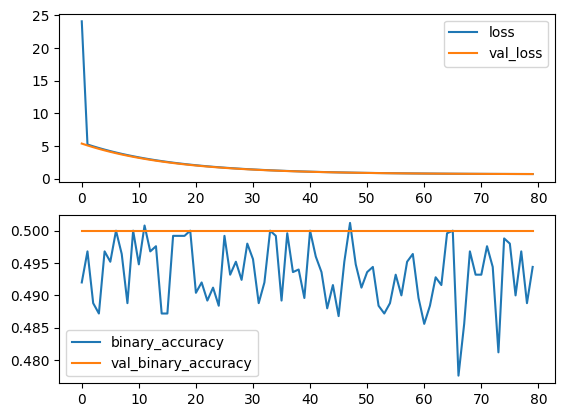

In [ ]:
import matplotlib.pyplot as plt

def plot_model_results(history):
  fig, axs = plt.subplots(2)
  axs[0].plot(history['loss'], label='loss')
  axs[0].plot(history['val_loss'], label='val_loss')
  axs[0].legend()

  axs[1].plot(history['binary_accuracy'], label="binary_accuracy")
  axs[1].plot(history['val_binary_accuracy'], label="val_binary_accuracy")
  axs[1].legend()

plot_model_results(history.history)

## Conclusions

After lots of tweaking around with the variety of columns and training epochs/layers, we couldn't push above 67% accuracy purely using general team stats.

# Adding More Game Specific Stats

Goal: Determine if conditions per game affect outcome

- Days rest prior to game

- Number of injuries (?)

In [ ]:
game_specific = prepare_dataset(season_2023, team_stats_2023)
game_specific

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN
0,Chicago Bulls,CHI,1610612741,0022301190,NYK,1610612752,L,0
1,Milwaukee Bucks,MIL,1610612749,0022301191,ORL,1610612753,L,0
2,Phoenix Suns,PHX,1610612756,0022301194,MIN,1610612750,W,1
3,Washington Wizards,WAS,1610612764,0022301186,BOS,1610612738,L,0
4,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0
...,...,...,...,...,...,...,...,...
2455,Toronto Raptors,TOR,1610612761,0022300069,MIN,1610612750,W,1
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0


## Rest Days

We get rest days between games by assigning game IDs to their game date (The API did not originally give these pieces of data together)

If a team is playing their first game, we set rest games to 0.

In [ ]:
from nba_api.stats.endpoints import leaguegamelog


log_2023 = leaguegamelog.LeagueGameLog(season=season_2023.formatted_season(), season_type_all_star="Regular Season")

log_2023 = log_2023.get_data_frames()[0]
log_2023

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1
1,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
2,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,...,31,49,19,11,6,11,23,104,-4,1
3,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,...,43,60,23,5,7,19,22,108,4,1
4,22023,1610612766,CHA,Charlotte Hornets,0022300063,2023-10-25,CHA vs. ATL,W,240,43,...,39,51,34,5,3,19,21,116,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,22023,1610612766,CHA,Charlotte Hornets,0022301187,2024-04-14,CHA @ CLE,W,240,46,...,37,47,36,10,9,10,11,120,10,1
2456,22023,1610612749,MIL,Milwaukee Bucks,0022301191,2024-04-14,MIL @ ORL,L,240,30,...,27,34,16,10,4,17,18,88,-25,1
2457,22023,1610612750,MIN,Minnesota Timberwolves,0022301194,2024-04-14,MIN vs. PHX,L,240,36,...,24,36,22,7,5,24,20,106,-19,1
2458,22023,1610612745,HOU,Houston Rockets,0022301199,2024-04-14,HOU @ LAC,W,240,50,...,42,59,31,7,8,18,13,116,11,1


In [ ]:
cleaned = log_2023[["GAME_ID", "GAME_DATE"]]
cleaned = cleaned.drop_duplicates()
cleaned

,GAME_ID,GAME_DATE
0,0022300061,2023-10-24
2,0022300062,2023-10-24
4,0022300063,2023-10-25
5,0022300065,2023-10-25
6,0022300068,2023-10-25
...,...,...
2440,0022301189,2024-04-14
2444,0022301193,2024-04-14
2445,0022301187,2024-04-14
2448,0022301198,2024-04-14


In [ ]:
rd_with_dates = pd.merge(game_specific, cleaned, how="left", on="GAME_ID")
rd_with_dates["LAST_GAME_DATE"] = rd_with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
rd_with_dates["LAST_GAME_DATE"] = rd_with_dates["LAST_GAME_DATE"].fillna(rd_with_dates["GAME_DATE"])
rd_with_dates["GAME_DATE"] = pd.to_datetime(rd_with_dates["GAME_DATE"])
rd_with_dates["LAST_GAME_DATE"] = pd.to_datetime(rd_with_dates["LAST_GAME_DATE"])
rd_with_dates["NUM_REST_DAYS"] = (rd_with_dates["GAME_DATE"] - rd_with_dates["LAST_GAME_DATE"]).dt.days
rd_with_dates

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Chicago Bulls,CHI,1610612741,0022301190,NYK,1610612752,L,0,2024-04-14,2024-04-12,2
1,Milwaukee Bucks,MIL,1610612749,0022301191,ORL,1610612753,L,0,2024-04-14,2024-04-12,2
2,Phoenix Suns,PHX,1610612756,0022301194,MIN,1610612750,W,1,2024-04-14,2024-04-12,2
3,Washington Wizards,WAS,1610612764,0022301186,BOS,1610612738,L,0,2024-04-14,2024-04-12,2
4,Cleveland Cavaliers,CLE,1610612739,0022301187,CHA,1610612766,L,0,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...
2455,Toronto Raptors,TOR,1610612761,0022300069,MIN,1610612750,W,1,2023-10-25,2023-10-25,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1,2023-10-24,2023-10-24,0
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0,2023-10-24,2023-10-24,0
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0,2023-10-24,2023-10-24,0


## Generalized approach

We can now generalize this approach into a function for each season

In [ ]:
# We assume the input is one of the basic DataFrame formats
# we created earlier in this notebook with each row
# corresponding to one team's view of a match
def add_days_rest_column(season: Season, basic_game_data: pd.DataFrame):
  log = leaguegamelog.LeagueGameLog(season=season.formatted_season(), season_type_all_star="Regular Season")
  log = log.get_data_frames()[0]

  deduplicated = log[["GAME_ID", "GAME_DATE"]]
  deduplicated = deduplicated.drop_duplicates()

  with_dates = pd.merge(basic_game_data, deduplicated, how="left", on="GAME_ID")
  with_dates["LAST_GAME_DATE"] = with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
  with_dates["LAST_GAME_DATE"] = with_dates["LAST_GAME_DATE"].fillna(with_dates["GAME_DATE"])
  with_dates["GAME_DATE"] = pd.to_datetime(with_dates["GAME_DATE"])
  with_dates["LAST_GAME_DATE"] = pd.to_datetime(with_dates["LAST_GAME_DATE"])
  with_dates["NUM_REST_DAYS"] = (with_dates["GAME_DATE"] - with_dates["LAST_GAME_DATE"]).dt.days
  return with_dates

add_days_rest_column(season_2023, games_2023)

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,0.573,0.598,1,2024-04-14,2024-04-12,2
1,Houston Rockets,HOU,1610612745,0022301199,LAC,1610612746,W,0.500,0.622,1,2024-04-14,2024-04-12,2
2,Philadelphia 76ers,PHI,1610612755,0022301192,BKN,1610612751,W,0.573,0.390,1,2024-04-14,2024-04-12,2
3,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0.598,0.573,0,2024-04-14,2024-04-12,2
4,Portland Trail Blazers,POR,1610612757,0022301200,SAC,1610612758,L,0.256,0.561,0,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Miami Heat,MIA,1610612748,0022300068,DET,1610612765,W,0.561,0.171,1,2023-10-25,2023-10-25,0
2456,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1,2023-10-24,2023-10-24,0
2457,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0,2023-10-24,2023-10-24,0
2458,Denver Nuggets,DEN,1610612743,0022300061,LAL,1610612747,W,0.695,0.573,1,2023-10-24,2023-10-24,0


## Neural Network + Rest Days

We apply rest days to our neural network

In [ ]:
rest_days_2021 = add_days_rest_column(season_2021, games_2021)
rest_days_2022 = add_days_rest_column(season_2022, games_2022)
rest_days_2023 = add_days_rest_column(season_2023, games_2023)

rest_days_merged = pd.concat([rest_days_2021, rest_days_2022, rest_days_2023])
rest_days_merged = rest_days_merged.sample(frac=1) # Shuffle the data
rest_days_merged

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
1580,Oklahoma City Thunder,OKC,1610612760,0022100444,LAC,1610612746,W,0.293,0.512,1,2021-12-18,2021-12-15,3
1943,Los Angeles Lakers,LAL,1610612747,0022200259,PHX,1610612756,L,0.524,0.549,0,2022-11-22,2022-11-20,2
800,Houston Rockets,HOU,1610612745,0022300798,NOP,1610612740,L,0.500,0.598,0,2024-02-22,2024-02-14,8
762,New York Knicks,NYK,1610612752,0022100845,POR,1610612757,L,0.451,0.329,0,2022-02-12,2022-02-10,2
2225,Indiana Pacers,IND,1610612754,0022300171,MIL,1610612749,W,0.573,0.598,1,2023-11-09,2023-11-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,Sacramento Kings,SAC,1610612758,0022200096,CHA,1610612766,W,0.585,0.329,1,2022-10-31,2022-10-29,2
1355,Memphis Grizzlies,MEM,1610612763,0022100562,CLE,1610612739,W,0.683,0.537,1,2022-01-04,2022-01-03,1
934,Indiana Pacers,IND,1610612754,0022300733,GSW,1610612744,L,0.573,0.561,0,2024-02-08,2024-02-06,2
2408,Golden State Warriors,GSW,1610612744,0022300087,SAC,1610612758,W,0.561,0.561,1,2023-10-27,2023-10-24,3


In [ ]:
rd_stat_labels = generate_nn_labels(["W_PCT"])
rd_stat_labels.append("NUM_REST_DAYS")
raw_rd_input = rest_days_merged[rd_stat_labels].to_numpy()
raw_rd_input

array([[0.293, 0.512, 3.   ],
       [0.524, 0.549, 2.   ],
       [0.5  , 0.598, 8.   ],
       ...,
       [0.573, 0.561, 2.   ],
       [0.561, 0.561, 3.   ],
       [0.78 , 0.329, 3.   ]])

In [ ]:
raw_rd_outputs = rest_days_merged["WIN"].to_numpy()
raw_rd_outputs

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
training_size = 5000

rd_train_input = raw_rd_input[:training_size]
rd_train_label = raw_rd_outputs[:training_size]

rd_test_input = raw_rd_input[training_size:]
rd_test_label = raw_rd_outputs[training_size:]

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5297 - loss: 0.7322 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5769 - val_loss: 0.7097
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5743 - loss: 0.7080 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6109 - val_loss: 0.7042
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6127 - loss: 0.7035 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5983 - val_loss: 0.7003
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6149 - loss: 0.6953 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6076 - val_loss: 0.6961
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6043 - loss: 0.6949 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6164 - val_loss: 0.6917
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━

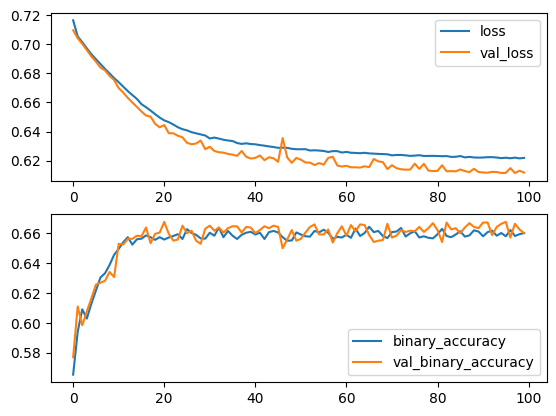

In [ ]:
from keras.regularizers import l2

lmbda = 0.01

rest_days_model = Sequential()
rest_days_model.add(keras.Input(shape=(3,)))
rest_days_model.add(Dense(20, activation = 'relu'))
rest_days_model.add(Dense(10, activation = 'relu'))
rest_days_model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

rest_days_model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

# fit the model to the training data
history = rest_days_model.fit(rd_train_input, rd_train_label, epochs=100, validation_data = (rd_test_input, rd_test_label))

result = rest_days_model.evaluate(x=rd_test_input, y=rd_test_label)
dict(zip(rest_days_model.metrics_names, result))

plot_model_results(history.history)

# Combining Stats with Batch Normalization

In [ ]:
bn_2021 = add_days_rest_column(season_2021, more_2021)
bn_2022 = add_days_rest_column(season_2022, more_2022)
bn_2023 = add_days_rest_column(season_2023, more_2023)

bn_merged = pd.concat([bn_2021, bn_2022, bn_2023])
bn_merged = bn_merged.sample(frac=1) # Shuffle the data
bn_merged

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,TEAM_FGA,...,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
1803,Oklahoma City Thunder,OKC,1610612760,0022100330,MEM,1610612763,L,0.293,0.683,7310,...,622,800,1462,1625,-664.0,466.0,0,2021-12-02,2021-12-01,1
1972,Atlanta Hawks,ATL,1610612737,0022100242,CHA,1610612766,W,0.524,0.524,7241,...,587,707,1668,1609,128.0,36.0,1,2021-11-20,2021-11-17,3
1185,Toronto Raptors,TOR,1610612761,0022300609,MEM,1610612763,L,0.305,0.329,7356,...,634,673,1487,1539,-528.0,-574.0,0,2024-01-22,2024-01-20,2
944,Phoenix Suns,PHX,1610612756,0022200762,TOR,1610612761,W,0.549,0.500,7388,...,585,772,1629,1604,170.0,121.0,1,2023-01-30,2023-01-28,2
1615,Houston Rockets,HOU,1610612745,0022300392,NOP,1610612740,W,0.500,0.598,7459,...,639,684,1609,1507,92.0,362.0,1,2023-12-23,2023-12-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,New Orleans Pelicans,NOP,1610612740,0022101160,LAL,1610612747,W,0.439,0.402,7212,...,680,626,1681,1647,-81.0,-250.0,1,2022-04-01,2022-03-30,2
1047,Orlando Magic,ORL,1610612753,0022300681,SAS,1610612759,W,0.573,0.268,6964,...,669,584,1710,1470,166.0,-532.0,1,2024-01-31,2024-01-29,2
1684,Atlanta Hawks,ATL,1610612737,0022300352,DET,1610612765,W,0.439,0.171,7584,...,615,531,1594,1457,-179.0,-747.0,1,2023-12-18,2023-12-16,2
704,Golden State Warriors,GSW,1610612744,0022300852,NYK,1610612752,W,0.561,0.610,7515,...,572,612,1471,1565,214.0,376.0,1,2024-02-29,2024-02-27,2


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - binary_accuracy: 0.5006 - loss: 0.7521 - val_binary_accuracy: 0.4849 - val_loss: 1.0341
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.5695 - loss: 0.6921 - val_binary_accuracy: 0.5534 - val_loss: 0.7010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.5827 - loss: 0.6846 - val_binary_accuracy: 0.5836 - val_loss: 0.6783
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.6158 - loss: 0.6663 - val_binary_accuracy: 0.6046 - val_loss: 0.6681
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6250 - loss: 0.6561 - val_binary_accuracy: 0.6210 - val_loss: 0.6617
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6241 - loss: 0.6524 - val_binary_accuracy: 0.6214 - val_loss: 0.6578
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6157 - loss: 0.6568 - val_binary_accuracy: 0.6248 - val_loss: 0.6554
Epoch 

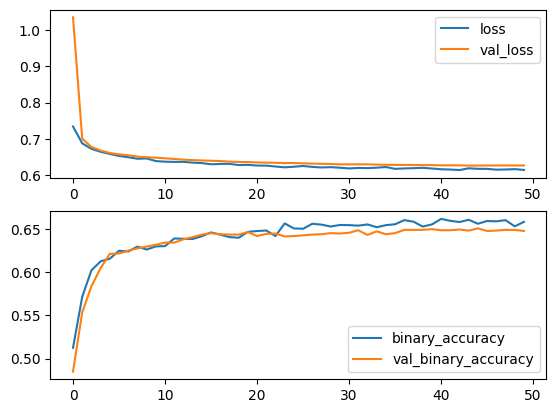

In [ ]:
bn_stats = generate_nn_labels(addl_stats)
bn_stats.append("NUM_REST_DAYS")
bn_raw_input_cols = bn_merged[bn_stats].to_numpy()

raw_bn_outputs = bn_merged["WIN"].to_numpy()

training_size = 5000

train_input = bn_raw_input_cols[:training_size]
train_label = raw_bn_outputs[:training_size]

test_input = bn_raw_input_cols[training_size:]
test_label = raw_bn_outputs[training_size:]

from keras.regularizers import l2
from keras.layers import BatchNormalization

lmbda = 0.01

bn_model = Sequential()
bn_model.add(keras.Input(shape=(27,)))
bn_model.add(BatchNormalization())
bn_model.add(Dense(20, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

bn_model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

# fit the model to the training data
history = bn_model.fit(train_input, train_label, epochs=50, validation_data = (test_input, test_label))

result = bn_model.evaluate(x=test_input, y=test_label)
dict(zip(bn_model.metrics_names, result))

plot_model_results(history.history)

# Pick 10 Random Games

In [ ]:
celtics_games_only = bn_merged[bn_merged["TEAM_ABBREVIATION"] == "BOS"]
celtics_games_only = celtics_games_only.sort_values("GAME_DATE")
celtics_games_only = celtics_games_only.reset_index()

chunk_size = 10 # Split into 10 consecutive games
list_of_dfs = [celtics_games_only[i:i + chunk_size] for i in range(0, celtics_games_only.shape[0], chunk_size)]
list_of_dfs[0]

,index,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,...,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,2439,Boston Celtics,BOS,1610612738,0022100005,NYK,1610612752,L,0.622,0.451,...,591,570,1592,1671,597.0,-10.0,0,2021-10-20,2021-10-20,0
1,2418,Boston Celtics,BOS,1610612738,0022100020,TOR,1610612761,L,0.622,0.585,...,591,738,1592,1563,597.0,188.0,0,2021-10-22,2021-10-20,2
2,2391,Boston Celtics,BOS,1610612738,0022100037,HOU,1610612745,W,0.622,0.244,...,591,600,1592,1812,597.0,-695.0,1,2021-10-24,2021-10-22,2
3,2378,Boston Celtics,BOS,1610612738,0022100041,CHA,1610612766,W,0.622,0.524,...,591,707,1592,1609,597.0,36.0,1,2021-10-25,2021-10-24,1
4,2348,Boston Celtics,BOS,1610612738,0022100056,WAS,1610612764,L,0.622,0.427,...,591,522,1592,1634,597.0,-277.0,0,2021-10-27,2021-10-25,2
5,2301,Boston Celtics,BOS,1610612738,0022100078,WAS,1610612764,L,0.622,0.427,...,591,522,1592,1634,597.0,-277.0,0,2021-10-30,2021-10-27,3
6,2265,Boston Celtics,BOS,1610612738,0022100098,CHI,1610612741,L,0.622,0.561,...,591,585,1592,1489,597.0,-32.0,0,2021-11-01,2021-10-30,2
7,2244,Boston Celtics,BOS,1610612738,0022100110,ORL,1610612753,W,0.622,0.268,...,591,555,1592,1501,597.0,-656.0,1,2021-11-03,2021-11-01,2
8,2219,Boston Celtics,BOS,1610612738,0022100121,MIA,1610612748,W,0.622,0.646,...,591,606,1592,1686,597.0,365.0,1,2021-11-04,2021-11-03,1
9,2185,Boston Celtics,BOS,1610612738,0022100136,DAL,1610612742,L,0.622,0.634,...,591,552,1592,1645,597.0,271.0,0,2021-11-06,2021-11-04,2


In [ ]:
print(test_input.shape)
print(test_label.shape)

(2380, 27)
(2380,)


In [ ]:
# Return number of games won in the chunk
def evaluate_chunk(games, debug=False) -> int:
  games = games.reset_index(drop=True)
  print("Evaluating chunk starting at: " + str(games.at[0, "GAME_DATE"]))
  games_won = 0
  for index, row in games.iterrows():
    game_input = row[bn_stats].to_numpy(dtype="float32")
    game_input = np.array([game_input])
    game_result = row[['WIN']].to_numpy(dtype="float32")
    result = bn_model.evaluate(x=game_input, y=game_result)
    if debug:
      print("Actual Result: {}, Predicted: {}".format(row['WIN'], result[1]))
    # We correctly predicted the result
    if result[1]:
      games_won += 1
  return games_won


games_correctly_guessed = []
for chunk in list_of_dfs:
  if len(chunk.index) != 10:
    # Not fair to count a chunk less than 10 games
    continue
  won = evaluate_chunk(chunk)
  games_correctly_guessed.append(won)

games_correctly_guessed

Evaluating chunk starting at: 2021-10-20 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.0000e+00 - loss: 0.9642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.0000e+00 - loss: 0.7459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 1.0000 - loss: 0.1666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 1.0000 - loss: 0.4965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.0000e+00 - loss: 1.3502
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.0000e+00 - loss: 1.3816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - binary_accuracy: 0.0000e+00 - loss: 1.0949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - binary_accuracy: 1.0000 - loss: 0.2869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - binary_accuracy: 1.0000 - loss: 0.6611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.0000e+00 - loss: 0.7662
Evaluating chunk starting at: 2021-11-10 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 1.0000 - loss: 0.5274
1/1 ━━━

[4, 6, 5, 4, 6, 9, 8, 8, 7, 9, 6, 4, 9, 5, 6, 6, 8, 7, 8, 8, 7, 9, 8, 8]

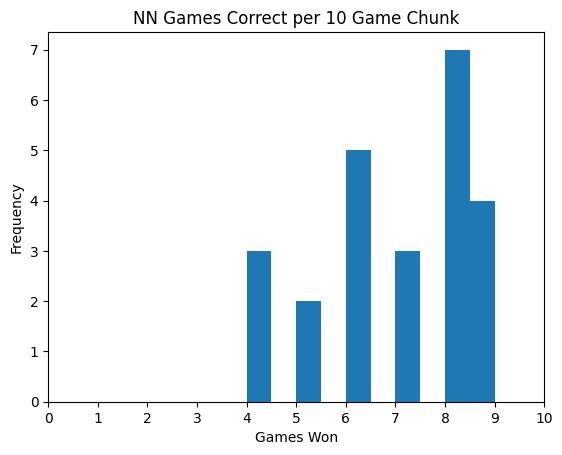

24


In [ ]:
plt.hist(games_correctly_guessed, density=False)
plt.title("NN Games Correct per 10 Game Chunk")
plt.ylabel('Frequency')
plt.xlabel('Games Won');
plt.xticks(np.arange(0, 11, step=1))
plt.show()

In [ ]:
CELTICS_ID = 1610612738
c_games = bn_merged[bn_merged["TEAM_ID"] == CELTICS_ID].sort_values("GAME_DATE")
ten = c_games.iloc[10:20]
X_ten = ten[bn_stats]
y_ten = ten["WIN"]

print(f"Games correct: {evaluate_chunk(ten, debug=True)}")

Evaluating chunk starting at: 2021-11-10 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 1.0000 - loss: 0.5274
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - binary_accuracy: 1.0000 - loss: 0.6849
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - binary_accuracy: 0.0000e+00 - loss: 0.9679
Actual Result: 0, Predicted: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - binary_accuracy: 1.0000 - loss: 0.4178
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - binary_accuracy: 0.0000e+00 - loss: 0.7609
Actual Result: 0, Predicted: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - binary_accuracy: 1.0000 - loss: 0.3333
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 1.0000 - loss: 0.3243
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 1.0000 - loss: 0.1666
Actual Result: 1, Predicted: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - binar